In [1]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
import bitstring as bs
class WSQ:
    
    """
    Attributes:
    _pixels (int): Number of pixels in source image.
    _Q ((16, ), ndarray): Quantization parameters q for each subband.
    _Z ((16, ), ndarray): Quantization parameters z for each subband.
    _bitstrings (list): List of 3 BitArrays, giving bit encodings for
    each group.
    _tvals (tuple): Tuple of 3 lists of bools, indicating which
    subbands in each groups were encoded.
    _shapes (tuple): Tuple of 3 lists of tuples, giving shapes of each
    subband in each group.
    _huff_maps (list): List of 3 dictionaries, mapping huffman index to
    bit pattern.
    """

    def __init__(self):
        self._pixels = None
        self._Q = None
        self._Z = None
        self._bitstrings = None
        self._tvals = None
        self._shapes= None
        self._huff_maps = None
        self._img = None
        self._recon_img = None
        
    def compress(self,img, r = 0.5, gamma=2.5):
        """The main compression routine. It computes and stores a bitstring
        representation of a compressed image, along with other values
        needed for decompression.
        Parameters:
        img ((m,n), ndarray): Numpy array containing 8-bit integer
        pixel values.
        r (float): Defines compression ratio. Between 0 and 1, smaller
        numbers mean greater levels of compression.
        gamma (float): A parameter used in quantization.
        """
        self._pixels = img.size 
        self._img = img # Store image size.
        subbands = self.decompose(img)

        # Calculate quantization parameters, quantize the image then group.
        self._Q, self._Z = self.get_bins(subbands, r, gamma)
        q_subbands = [self.quantize(subbands[i],self._Q[i],self._Z[i])
                      for i in range(16)]
        groups, self._shapes, self._tvals = self.group(q_subbands)

        # Complete the Huffman encoding and transfer to bitstring.
        huff_maps = []
        bitstrings = []
        for i in range(3):
            inds, freqs, extra = self.huffman_indices(groups[i])
            huff_map = huffman(freqs)
            huff_maps.append(huff_map)
            bitstrings.append(self.encode(inds, extra, huff_map))

        # Store the bitstrings and the huffman maps.
        self._bitstrings = bitstrings
        self._huff_maps = huff_maps

    def decompose(self, img):
        """Decompose an image into the WSQ subband pattern using the Coiflet1 wavelet.
        Parameters:
        img ((m,n) ndarray): Numpy array holding the image to be
        decomposed.
        Returns:
        subbands (list): List of 16 numpy arrays containing the WSQ
        subbands in order.
            """
        lwt = pywt.wavedec2(img, wavelet = 'db4', level = 5)

        subbands_list =[]
        for i in range (len(lwt)):
            if i == 0:
                subbands_list.append(lwt[0])
            if i!=0:
                for j in range (3):
                    subbands_list.append(lwt[i][j])
        return subbands_list
    
    def recreate(self, subbands):
        """Recreate an image from the 16 WSQ subbands.
        Parameters:
        subbands (list): List of 16 numpy arrays containing the WSQ
        subbands in order.
        Returns:
        img ((m,n) ndarray): Numpy array, the image recreated from the
        WSQ subbands.
        """
        ordered_subbands = []
        for i in range (len(subbands)):
            if i ==0:
                ordered_subbands.append(subbands[i])
            else:
                if i==1:
                    lst =[]
                lst.append(subbands[i])
                if len(lst)==3:
                    ordered_subbands.append(lst)
                    lst = []
       
        invlwt = pywt.waverec2(ordered_subbands,wavelet = 'db4')
        x = invlwt.astype(np.uint8)
        return x
    
    def get_bins(self, subbands, r, gamma):
        """Calculate quantization bin widths for each subband. These will
        be used to quantize the wavelet coefficients.
        Parameters:
        subbands (list): List of 16 WSQ subbands.
        r (float): Compression parameter, determines the degree of
        compression.
        gamma(float): Parameter used in compression algorithm.
        Returns:
        Q ((16, ) ndarray): Array of quantization step sizes.
        Z ((16, ) ndarray): Array of quantization coefficients.
        """
        subband_vars = np.zeros(16)
        fracs = np.zeros(16)
        for i in range(len(subbands)): # Compute subband variances.
            X,Y = subbands[i].shape
            fracs[i]=(X*Y)/(np.float(img.shape[0]*img.shape[1]))
            x = np.floor(X/8.).astype(int)
            y = np.floor(9*Y/32.).astype(int)
            Xp = np.floor(3*X/4.).astype(int)
            Yp = np.floor(7*Y/16.).astype(int)
            mu = subbands[i].mean()
            sigsq = (Xp*Yp-1.)**(-1)*((subbands[i][x:x+Xp, y:y+Yp]-mu)**2).sum()
            subband_vars[i] = sigsq
        A = np.ones(16)
        A[13], A[14] = [1.32]*2
        Qprime = np.zeros(16)
        mask = subband_vars >= 1.01
        Qprime[mask] = 10./(A[mask]*np.log(subband_vars[mask]))
        Qprime[:4] = 1
        Qprime[15] = 0
        K = []
        for i in range(15):
            if subband_vars[i] >= 1.01:
                K.append(i)
        while True:
            S = fracs[K].sum()
            P = ((np.sqrt(subband_vars[K])/Qprime[K])**fracs[K]).prod()
            q = (gamma**(-1))*(2**(r/S-1))*(P**(-1./S))
            E = []
            for i in K:
                if Qprime[i]/q >= 2*gamma*np.sqrt(subband_vars[i]):
                    E.append(i)
            if len(E) > 0:
                for i in E:
                    K.remove(i)
                continue
            break
        Q = np.zeros(16) # Final bin widths.
        for i in K:
            Q[i] = Qprime[i]/q
        Z = 1.2*Q
        return Q, Z

    def quantize(self, coeffs, Q, Z):
        """Implementation of a uniform quantizer which maps wavelet
        coefficients to integer values using the quantization parameters
        Q and Z.
        Parameters:
        coeffs ((m,n) ndarray): Contains the floating-point values to
        be quantized.
        Q (float): The step size of the quantization.
        Z (float): The null-zone width (of the center quantization bin).
        Returns
        out ((m,n) ndarray): Numpy array of the quantized values.
        """
        q_coeffs = np.zeros([coeffs.shape[0],coeffs.shape[1]])
        if Q == 0:
            q_coeffs[:,:] =0

        else:
            for i in range (coeffs.shape[0]):
                for j in range(coeffs.shape[1]):
                    a = coeffs[i][j]
                    if a > (Z/2):
                        q_coeffs[i][j] = np.floor((a-Z/2)/Q) + 1
                    elif a <= Z/2 and a >= (-Z/2):
                        q_coeffs[i][j] = 0
                    elif a < (-Z/2):
                        q_coeffs[i][j] = np.ceil((a+Z/2)/Q) - 1
        return q_coeffs
                                     
    def dequantize(self, coeffs, Q, Z, C=0.44):
        """Given quantization parameters, approximately reverses the
        quantization effect carried out in quantize().
        Parameters:
        coeffs ((m,n) ndarray): Array of quantized coefficients.
        Q (float): The step size of the quantization.
        Z (float): The null-zone width (of the center quantization bin).
        C (float): Centering parameter, defaults to .44.
        Returns:
        out ((m,n) ndarray): Array of dequantized coefficients.
        """

        deq_coeffs = np.zeros([coeffs.shape[0],coeffs.shape[1]])
        if Q == 0:
            deq_coeffs[:,:] =0
        else:
            for i in range (coeffs.shape[0]):
                for j in range(coeffs.shape[1]):
                    p = coeffs[i][j]
                    if p > 0:
                        deq_coeffs[i][j] = (p - C)*Q + Z/2
                    elif p == 0:
                        deq_coeffs[i][j] = 0
                    elif p < 0:
                        deq_coeffs[i][j] = (p + C)*Q - Z/2   

        return deq_coeffs
    
    def group(self, subbands):
        """Split the quantized subbands into 3 groups.
        Parameters:
        subbands (list): Contains 16 numpy arrays which hold the
        quantized coefficients.
        Returns:
        gs (tuple): (g1,g2,g3) Each gi is a list of quantized coeffs
        for group i.
        ss (tuple): (s1,s2,s3) Each si is a list of tuples which
        contain the shapes for group i.
        ts (tuple): (s1,s2,s3) Each ti is a list of bools indicating
        which subbands were included.
        """
        g1 = [] # This will hold the group 1 coefficients.
        s1 = [] # Keep track of the subband dimensions in group 1.
        t1 = [] # Keep track of which subbands were included.
        for i in range(10):
            s1.append(subbands[i].shape)
            if subbands[i].any(): # True if there is any nonzero entry.
                g1.extend(subbands[i].ravel())
                t1.append(True)
            else: # The subband was not transmitted.
                t1.append(False)
        g2 = [] # This will hold the group 2 coefficients.
        s2 = [] # Keep track of the subband dimensions in group 2.
        t2 = [] # Keep track of which subbands were included.
        for i in range(10, 13):
            s2.append(subbands[i].shape)
            if subbands[i].any(): # True if there is any nonzero entry.
                g2.extend(subbands[i].ravel())
                t2.append(True)
            else: # The subband was not transmitted.
                t2.append(False)
        g3 = [] # This will hold the group 3 coefficients.
        s3 = [] # Keep track of the subband dimensions in group 3.
        t3 = [] # Keep track of which subbands were included.
        for i in range(13,16):
            s3.append(subbands[i].shape)
            if subbands[i].any(): # True if there is any nonzero entry.
                g3.extend(subbands[i].ravel())
                t3.append(True)
            else: # The subband was not transmitted.
                t3.append(False)
        return (g1,g2,g3), (s1,s2,s3), (t1,t2,t3)

    def ungroup(self, gs, ss, ts):
        """Re-create the subband list structure from the information stored
        in gs, ss and ts.
        Parameters:
        gs (tuple): (g1,g2,g3) Each gi is a list of quantized coeffs
        for group i.
        ss (tuple): (s1,s2,s3) Each si is a list of tuples which
        contain the shapes for group i.
        ts (tuple): (s1,s2,s3) Each ti is a list of bools indicating
        which subbands were included.
        Returns:
        subbands (list): Contains 16 numpy arrays holding quantized
        coefficients.
        """
        subbands1 = [] # The reconstructed subbands in group 1.
        i = 0
        for j, shape in enumerate(ss[0]):
            if ts[0][j]: # True if the j-th subband was included.
                l = shape[0]*shape[1] # Number of entries in the subband.
                subbands1.append(np.array(gs[0][i:i+l]).reshape(shape))
                i += l
            else: # The j-th subband wasn't included, so all zeros.
                subbands1.append(np.zeros(shape))    

        subbands2 = [] # The reconstructed subbands in group 2.
        i = 0
        for j, shape in enumerate(ss[1]):
            if ts[1][j]: # True if the j-th subband was included.
                l = shape[0]*shape[1] # Number of entries in the subband.
                subbands2.append(np.array(gs[1][i:i+l]).reshape(shape))
                i += l
            else: # The j-th subband wasn't included, so all zeros.
                subbands2.append(np.zeros(shape))
        subbands3 = [] # the reconstructed subbands in group 3
        i = 0
        for j, shape in enumerate(ss[2]):
            if ts[2][j]: # True if the j-th subband was included.
                l = shape[0]*shape[1] # Number of entries in the subband.
                subbands3.append(np.array(gs[2][i:i+l]).reshape(shape))
                i += l
            else: # The j-th subband wasn't included, so all zeros.
                subbands3.append(np.zeros(shape))
        subbands1.extend(subbands2)
        subbands1.extend(subbands3)
        return subbands1

    def huffman_indices(self, coeffs):
        """Calculate the Huffman indices from the quantized coefficients.
        Parameters:
        coeffs (list): Integer values that represent quantized
        coefficients.
        Returns:
        inds (list): The Huffman indices.
        freqs (ndarray): Array whose i-th entry gives the frequency of
        index i.
        extra (list): Contains zero run lengths and coefficient
        magnitudes for exceptional cases.
        """
        N = len(coeffs)
        i = 0
        inds = []
        extra = []
        freqs = np.zeros(254)
        # Sweep through the quantized coefficients.
        while i < N:
        # First handle zero runs.
            zero_count = 0
            while coeffs[i] == 0:
                zero_count += 1
                i += 1
                if i >= N:
                    break
            if zero_count > 0 and zero_count < 101:
                inds.append(zero_count - 1)
                freqs[zero_count - 1] += 1
            elif zero_count >= 101 and zero_count < 256: # 8 bit zero run.
                inds.append(104)
                freqs[104] += 1
                extra.append(zero_count)
            elif zero_count >= 256: # 16 bit zero run.
                inds.append(105)
                freqs[105] += 1
                extra.append(zero_count)
            if i >= N:
                break

            # now handle nonzero coefficients
            if coeffs[i] > 74 and coeffs[i] < 256: # 8 bit pos coeff.
                inds.append(100)
                freqs[100] += 1
                extra.append(coeffs[i])
            elif coeffs[i] >= 256: # 16 bit pos coeff.
                inds.append(102)
                freqs[102] += 1
                extra.append(coeffs[i])
            elif coeffs[i] < -73 and coeffs[i] > -256: # 8 bit neg coeff.
                inds.append(101)
                freqs[101] += 1
                extra.append(abs(coeffs[i]))
            elif coeffs[i] <= -256: # 16 bit neg coeff.
                inds.append(103)
                freqs[103] += 1
                extra.append(abs(coeffs[i]))
            else: # Current value is a nonzero coefficient in the range [-73, ←-74].
                inds.append(179 + coeffs[i])
                freqs[179 + coeffs[i].astype(int)] += 1
            i += 1
        return list(map(int,inds)), list(map(int,freqs)), list(map(int,extra))

    def indices_to_coeffs(self, indices, extra):
        """Calculate the coefficients from the Huffman indices plus extra
        values
        Parameters:
        indices (list): List of Huffman indices.
        extra (list): Indices corresponding to exceptional values.
        Returns:
        coeffs (list): Quantized coefficients recovered from the indices.
        """
        coeffs = []
        j = 0 # Index for extra array.
        for s in indices:
            if s < 100: # Zero count of 100 or less.
                coeffs.extend(np.zeros(s+1))
            elif s == 104 or s == 105: # Zero count of 8 or 16 bits.
                coeffs.extend(np.zeros(extra[j]))
                j += 1
            elif s in [100, 102]: # 8 or 16 bit pos coefficient.
                coeffs.append(extra[j]) # Get the coefficient from the extra ←-list.
                j += 1
            elif s in [101, 103]: # 8 or 16 bit neg coefficient.
                coeffs.append(-extra[j]) # Get the coefficient from the extra ←-list.
                j += 1
            else: # Coefficient from -73 to +74.
                coeffs.append(s-179)
        return coeffs

    def encode(self, indices, extra, huff_map):
        """Encodes the indices using the Huffman map, then returns
        the resulting bitstring.
        Parameters:
        indices (list): Huffman Indices.
        extra (list): Indices corresponding to exceptional values.
        huff_map (dict): Dictionary that maps Huffman index to bit
        pattern.
        Returns:
        bits (BitArray object): Contains bit representation of the
        Huffman indices.
        """
        bits = bs.BitArray()
        j = 0 # Index for extra array.
        for s in indices: # Encode each huffman index.
            bits.append('0b' + huff_map[s])
            # Encode extra values for exceptional cases.
            if s in [104, 100, 101]: # Encode as 8-bit ints.
                bits.append('uint:8={}'.format(int(extra[j])))
                j += 1
            elif s in [102, 103, 105]: # Encode as 16-bit ints.
                bits.append('uint:16={}'.format(int(extra[j])))
                j += 1
        return bits
            
    def decode(self, bits, huff_map):
        """Decodes the bits using the given huffman map, and returns
        the resulting indices.
        Parameters:
        bits (BitArray object): Contains bit-encoded Huffman indices.
        huff_map (dict): Maps huffman indices to bit pattern.
        Returns:
        indices (list): Decoded huffman indices.
        extra (list): Decoded values corresponding to exceptional indices.
        """
        indices = []
        extra = []
        # Reverse the huffman map to get the decoding map.
        dec_map = {v:k for k, v in huff_map.items()}

        # Wrap the bits in an object better suited to reading.
        bits = bs.ConstBitStream(bits)
        # Read each bit at a time, decoding as we go.
        i = 0 # The index of the current bit.
        pattern = '' # The current bit pattern.
        while i < bits.length:
            pattern += bits.read('bin:1') # Read in another bit.
            i += 1
            # Check if current pattern is in the decoding map.
            if pattern in dec_map:
                indices.append(dec_map[pattern]) # Insert huffman index.
                    # If an exceptional index, read next bits for extra value.
                if dec_map[pattern] in (100, 101, 104): # 8-bit int or 8-bit ←-zero run length.
                    extra.append(bits.read('uint:8'))
                    i += 8
                elif dec_map[pattern] in (102, 103, 105): # 16-bit int or 16-←-bit zero run length.
                    extra.append(bits.read('uint:16'))
                    i += 16
                pattern = '' # Reset the bit pattern.

        return indices, extra

    def decompress(self):
        """Return the uncompressed image recovered from the compressed
        bistring representation.
        Returns:
        img ((m,n) ndaray): The recovered, uncompressed image.
        """
        # For each group, decode the bits, map from indices to coefficients.
        groups = []
        for i in range(3):
            indices, extras = self.decode(self._bitstrings[i],self._huff_maps[i])
            groups.append(self.indices_to_coeffs(indices, extras))

        # Recover the subbands from the groups of coefficients.
        q_subbands = self.ungroup(groups, self._shapes, self._tvals)

        # Dequantize the subbands.
        subbands = [self.dequantize(q_subbands[i], self._Q[i], self._Z[i])
                    for i in range(16)]
        # Recreate the image.
        recon_img = self.recreate(subbands)
        self._recon_img = recon_img

        return recon_img
            
    def get_ratio(self):
        """Calculate the compression ratio achieved.
        Returns:
        ratio (float): Ratio of number of bytes in the original image
        to the number of bytes contained in the bitstrings.
        """
        input_image_size = 8*self._pixels
        bitstream_size = len(self._bitstrings[0]) + len(self._bitstrings[1]) + len(self._bitstrings[2]) 
        compression_ratio = input_image_size/bitstream_size
        print('Size of the image is: ', input_image_size)
        print('Size of bit stream: ', bitstream_size)
        return compression_ratio
    
    def MSE(self):
        print(self._img[0][0],self._recon_img[0][0])
        sum1 = 0
        for i in range (self._img.shape[0]):
            for j in range (self._img.shape[1]):
                s = (self._img[i][j] - self._recon_img[i][j])*(self._img[i][j] - self._recon_img[i][j])
                sum1+=s
        mse = sum1/(self._img.shape[0]*self._img.shape[1])
        print('MSE:',mse)
        PSNR = 20 * np.log10(255/(np.sqrt(mse)))
        print('PSNR:',PSNR)
        return 
# Helper functions and classes for the Huffman encoding portions of WSQ ←-algorithm.

import queue

class huffmanLeaf():
    
    """Leaf node for Huffman tree."""
    def __init__(self, symbol):
        self.symbol = symbol
        
    def makeMap(self, huff_map, path):
        huff_map[self.symbol] = path
        
    def __str__(self):
        return str(self.symbol)
    
    def __lt__(self,other):
        return False
    
    
class huffmanNode():
    """Internal node for Huffman tree."""
    
    def __init__(self, left, right):
        self.left = left
        self.right = right
        
    def makeMap(self, huff_map, path):
        """Traverse the huffman tree to build the encoding map."""
        self.left.makeMap(huff_map, path + '0')
        self.right.makeMap(huff_map, path + '1')
        
    def __lt__(self,other):
        return False
    
def huffman(freqs):
    """
    Generate the huffman tree for the given symbol frequencies.
    Return the map from symbol to bit pattern.
    """
    q = queue.PriorityQueue()
    for i in range(len(freqs)):
        leaf = huffmanLeaf(i)
        q.put((freqs[i], leaf))
    while q.qsize() > 1:
        l1 = q.get()
        l2 = q.get()
        weight = l1[0] + l2[0]
        node = huffmanNode(l1[1], l2[1])
        q.put((weight,node))
    root = q.get()[1]
    huff_map = dict()
    root.makeMap(huff_map, '')
    return huff_map

Size of the image is:  2097152
Size of bit stream:  71668
Compression ratio achieved:  29.26204163643467
141 137


<ipython-input-1-9f5dabb9dd1e>:507: RuntimeWarning: overflow encountered in ubyte_scalars
  s = (self._img[i][j] - self._recon_img[i][j])*(self._img[i][j] - self._recon_img[i][j])


MSE: 30.551170349121094
PSNR: 33.280525090903325


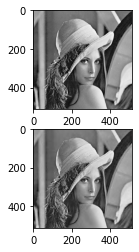

In [ ]:
import cv2
img = cv2.imread('greyscale_lenna.jpg',0)

wsq = WSQ()
wsq.compress(img)
new_image = wsq.decompress()
print('Compression ratio achieved: ', wsq.get_ratio())

wsq.MSE()
plt.subplot(211)
plt.imshow(img, cmap=plt.cm.Greys_r)
plt.subplot(212)
plt.imshow(np.abs(new_image), cmap=plt.cm.Greys_r)
plt.show()
cv2.imshow('input_image',img)
plt.show()
cv2.imshow('Reconstructed_image',new_image)
plt.show()
cv2.waitKey(0)
cv2.destroyAllWindows()

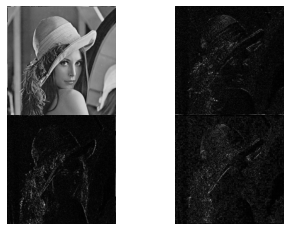

In [2]:
import cv2
import pywt
import numpy as np

img = cv2.imread('greyscale_lenna.jpg',0)
#dimensions = img.shape
#print(dimensions)

lwt = pywt.dwt2(img, 'db4', mode='per')

plt.subplot(221)
plt.imshow(lwt[0], cmap='gray')
plt.axis('off')
plt.subplot(222)
plt.imshow(np.abs(lwt[1][0]), cmap='gray')
plt.axis('off')
plt.subplot(223)
plt.imshow(np.abs(lwt[1][1]), cmap='gray')
plt.axis('off')
plt.subplot(224)
plt.imshow(np.abs(lwt[1][2]), cmap='gray')
plt.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)